<a href="https://colab.research.google.com/github/Song-z-h/data-intensive-proj/blob/master/recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto: Book Recommendation

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

zhaohui.song@studio.unibo.it  giuseppe.pintus2@studio.unibo.it


In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dataset
https://www.kaggle.com/code/sercanyesiloz/book-recommendation-system/input?select=Books+Data+with+Category+Language+and+Summary

In order to import the dataset, you should downlaod the dataset, and load it to this notebook, then change the url path to load the dataset, you can find the code below

### Project objective

We have a dataset of books, users, and the ratings to these books given by users, and we want to predict user ratings and give recomendations

Contributions:
- Analysis of our user, examine the quality of their ratings
- Individual potential bias in the collected data and outliers
- Hands on the ulity matrix, and coduct k-nn parameter search
- Test several recomendation systems for our book dataset using surprise
- Test the probabilistic recomendation model
- Analysis of comparision between different benchmarks (rmse, mse)
- 2 ways to give recomendation

# Importation data & libraries

In [ ]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import gc

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [200]:
import zipfile

#substitute this path with the path in your drive, or just load the zip file
with zipfile.ZipFile('drive/MyDrive/dataintensive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [201]:
import pandas as pd

df = pd.read_csv('data/Preprocessed_data.csv')

# Data Description

This dataset contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

## General data description

In [202]:
df.head(5)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada


## We have mixed unprocessed data, but they can be divided into 2 main sections

### users
- user_id The unique id associated to the user
- location User's location as a string
- age The user's age
- rating A rating to a book
- city The city of the user
- state The state of the country where the user lives
- country The country of the user

### books

- isbn Unique Id associated to the book
- book_title The title of the book
- book_author The author of the book
- year_of_publication The year when the book was officially published
- publisher The publisher of the book
- img_s, img_l, img_m The cover image of the book
- Sumarry A description of the coentent
- Language The language the book was writen in


We checked the ratings count for each score.

In [203]:
rating_counts = df['rating'].value_counts().reset_index()
# Rename the columns for clarity
rating_counts.columns = ['rating', 'count']

# Sort the DataFrame by the "rating" column if needed
rating_counts = rating_counts.sort_values(by='rating')

# Print the result
print(rating_counts)

    rating   count
0        0  647323
10       1    1481
9        2    2375
8        3    5118
7        4    7617
5        5   45355
6        6   31689
3        7   66404
1        8   91806
4        9   60780
2       10   71227


This prints shows that a lot of user gave 0 score to the books, We are not sure if these data are fake, or the service is really that bad. For the sake of project, we do not explore the reason behind.

In [204]:
df.describe()

,Unnamed: 0,user_id,age,rating,year_of_publication
count,1.031175e+06,1.031175e+06,1.031175e+06,1.031175e+06,1.031175e+06
mean,5.155870e+05,1.405944e+05,3.642902e+01,2.839022e+00,1.995283e+03
std,2.976747e+05,8.052444e+04,1.035354e+01,3.854149e+00,7.309340e+00
min,0.000000e+00,2.000000e+00,5.000000e+00,0.000000e+00,1.376000e+03
25%,2.577935e+05,7.041500e+04,3.100000e+01,0.000000e+00,1.992000e+03
50%,5.155870e+05,1.412100e+05,3.474390e+01,0.000000e+00,1.997000e+03
75%,7.733805e+05,2.114260e+05,4.100000e+01,7.000000e+00,2.001000e+03
max,1.031174e+06,2.788540e+05,9.900000e+01,1.000000e+01,2.008000e+03


From this graph, we can see that the average age of our users are 36 years old, and the average rating is 2.83.

## Users description

### Data distribution

The objective of this section is to provide meanings to the user distribution.

In [205]:
user_df = df[["user_id", "city", "state", "country", "age"]]
user_df.head(5)

,user_id,city,state,country,age
0,2,stockton,california,usa,18.0000
1,8,timmins,ontario,canada,34.7439
2,11400,ottawa,ontario,canada,49.0000
3,11676,NaN,NaN,NaN,34.7439
4,41385,sudbury,ontario,canada,34.7439


Most of the users come from NA.

In [206]:
country_counts = user_df["country"].value_counts()
country_counts

usa                     745840
canada                   92957
united kingdom           32011
germany                  27655
australia                18217
                         ...  
victoria, australia          1
lebanon                      1
x                            1
china"                       1
päijät-häme, finland         1
Name: country, Length: 414, dtype: int64

We drop the outliers like those who comes from like `x` or `china"`, only keeping those with more than 1000 ratings per country

In [207]:
filtered_country_counts = country_counts[country_counts >= 1000]

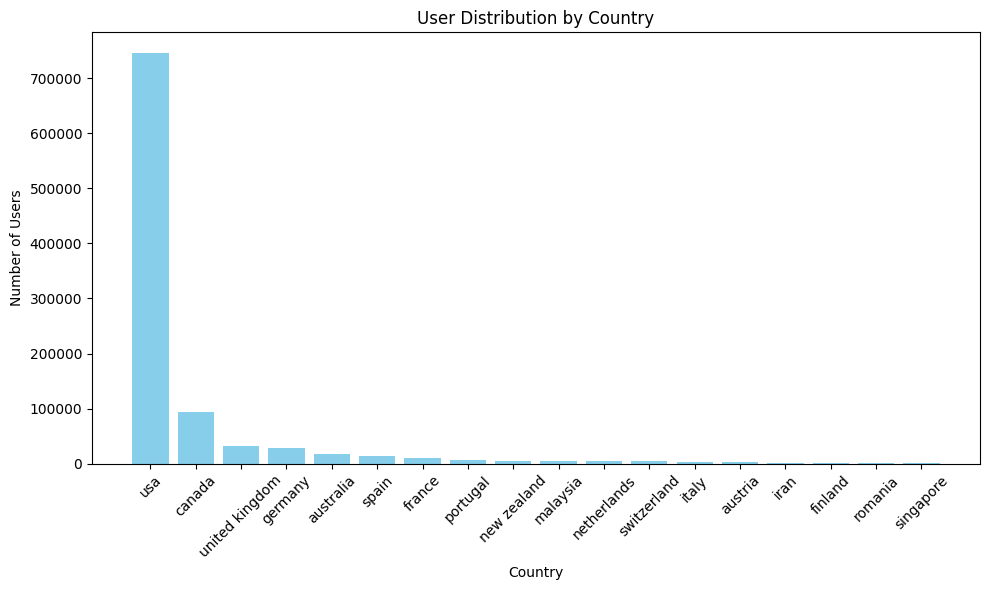

In [208]:
# Create a histogram chart
plt.figure(figsize=(10, 6))
plt.bar(filtered_country_counts.index, filtered_country_counts.values, color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('User Distribution by Country')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the histogram
plt.show()

This graph shows that most of the book ratings come from North America users, we need to be aware that if we used this data to generate predictions for an user who comes from a rare country, it might be not accurate, thus potentially biased

<Axes: title={'center': 'Age'}, ylabel='Frequency'>

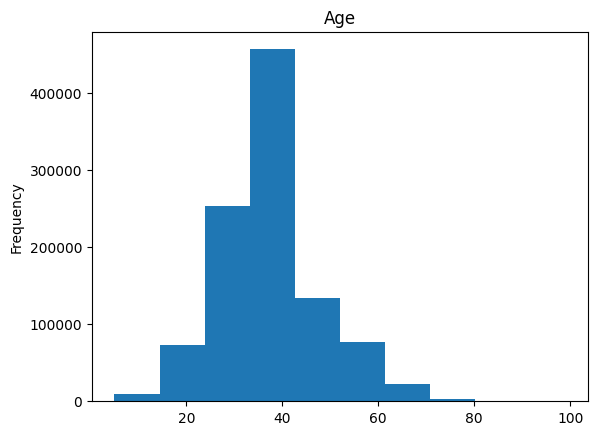

In [209]:
user_df["age"].plot(kind = 'hist', title = 'Age')

Most of the users are aged between 20 and 60 years old.

### Data quality

This section provides an analysis on the quality of ratings provided by the users

In [210]:
user_df = df[["user_id", "country", "age", "rating"]]

In [211]:
user_df

,user_id,country,age,rating
0,2,usa,18.0000,0
1,8,canada,34.7439,5
2,11400,canada,49.0000,0
3,11676,NaN,34.7439,8
4,41385,canada,34.7439,0
...,...,...,...,...
1031170,278851,usa,33.0000,0
1031171,278851,usa,33.0000,5
1031172,278851,usa,33.0000,7
1031173,278851,usa,33.0000,7


In [212]:
user_df.describe()

,user_id,age,rating
count,1.031175e+06,1.031175e+06,1.031175e+06
mean,1.405944e+05,3.642902e+01,2.839022e+00
std,8.052444e+04,1.035354e+01,3.854149e+00
min,2.000000e+00,5.000000e+00,0.000000e+00
25%,7.041500e+04,3.100000e+01,0.000000e+00
50%,1.412100e+05,3.474390e+01,0.000000e+00
75%,2.114260e+05,4.100000e+01,7.000000e+00
max,2.788540e+05,9.900000e+01,1.000000e+01


In [213]:
print("number of ratings", len(user_df))
print("number of users", user_df["user_id"].nunique())
print("number of countries", user_df["country"].nunique())
print("average number of ratings", user_df["user_id"].value_counts().mean())
print("average rating", user_df["rating"].mean())

number of ratings 1031175
number of users 92107
number of countries 414
average number of ratings 11.19540317239732
average rating 2.8390215045942737


We want to know per single user, what is the average rating given by him, and what is the rating counts. We will create a new dataframe with these 2 additional columns.

In [214]:
user_num_ratings = df.groupby('user_id')['rating'].count().reset_index()
user_num_ratings.columns = ['user_id', 'num_ratings']

In [215]:
user_avg_rating = df.groupby('user_id')['rating'].mean().reset_index()
user_avg_rating.columns = ['user_id', 'avg_rating']

In [216]:
user_df = user_df.drop('rating', axis=1)

In [217]:
user_df = user_df.drop_duplicates()
user_df

,user_id,country,age
0,2,usa,18.0000
1,8,canada,34.7439
2,11400,canada,49.0000
3,11676,NaN,34.7439
4,41385,canada,34.7439
...,...,...,...
1031143,278636,usa,34.7439
1031149,278659,usa,33.0000
1031151,278713,usa,63.0000
1031152,278714,usa,34.7439


In [218]:
merged_df = pd.merge(user_df, user_num_ratings, on='user_id', how='left')
merged_df = pd.merge(merged_df, user_avg_rating, on='user_id', how='left')
merged_df

,user_id,country,age,num_ratings,avg_rating
0,2,usa,18.0000,1,0.000000
1,8,canada,34.7439,17,2.294118
2,11400,canada,49.0000,62,2.000000
3,11676,NaN,34.7439,11144,4.582645
4,41385,canada,34.7439,10,0.000000
...,...,...,...,...,...
92102,278636,usa,34.7439,1,5.000000
92103,278659,usa,33.0000,1,10.000000
92104,278713,usa,63.0000,1,8.000000
92105,278714,usa,34.7439,1,0.000000


As you can see, this table has 2 agumented columns that displays the quality of each user account.

We drop those users who rated less than 3 times.

In [219]:
threshold = 3  # Adjust this threshold as needed
filtered_df_new = merged_df[merged_df['num_ratings'] >= threshold]

In [220]:
filtered_df_new

,user_id,country,age,num_ratings,avg_rating
1,8,canada,34.7439,17,2.294118
2,11400,canada,49.0000,62,2.000000
3,11676,NaN,34.7439,11144,4.582645
4,41385,canada,34.7439,10,0.000000
5,67544,canada,30.0000,12,5.000000
...,...,...,...,...,...
91739,261160,spain,39.0000,5,7.400000
91809,265051,spain,40.0000,3,4.666667
91891,268180,usa,71.0000,3,5.000000
92068,276442,switzerland,62.0000,3,6.333333


Since there are a lot of typo on the contries, we have many unsensical country names. To this end, we try to plot the top k country on the chart.

In [221]:
k = 10
filtered_df = filtered_df_new[filtered_df_new['country'] != 'usa']
filtered_df = filtered_df[filtered_df['country'] != 'canada']

country_rating_counts = filtered_df['country'].value_counts().reset_index()
country_rating_counts.columns = ['country', 'rating_count']
top_k_countries = country_rating_counts.sort_values(by='rating_count', ascending=False).head(k)
top_k_countries


,country,rating_count
0,germany,1505
1,united kingdom,1156
2,australia,653
3,spain,617
4,france,340
5,italy,251
6,switzerland,215
7,portugal,204
8,netherlands,188
9,new zealand,149


In [222]:
filtered_df = filtered_df[filtered_df['country'].isin(top_k_countries['country'])]
filtered_df.head(5)

,user_id,country,age,num_ratings,avg_rating
62,24539,spain,34.7439,135,0.000000
65,189238,new zealand,34.7439,3,2.000000
76,213915,united kingdom,29.0000,105,1.352381
95,13582,portugal,29.0000,168,2.916667
115,29654,germany,42.0000,6,4.833333


We plot the relationship between age and average ratings.

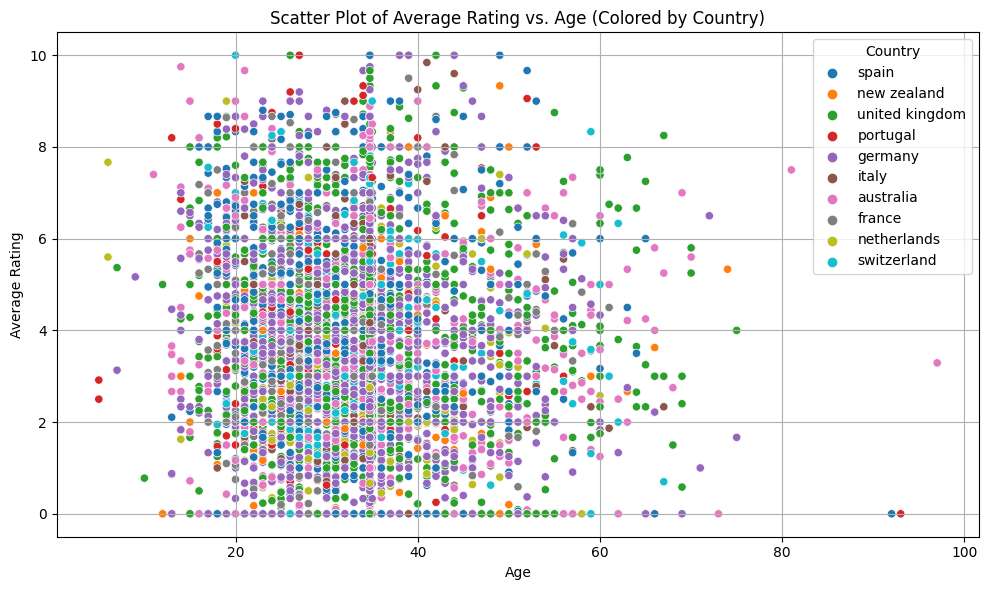

In [223]:
# Create a scatter plot with 'country' as the color feature using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='avg_rating', hue='country', data=filtered_df, palette='tab10')
plt.xlabel('Age')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Rating vs. Age (Colored by Country)')
plt.grid(True)
plt.legend(title='Country', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

Some users have the rating average of zero, if they rated zero to all books they received, that will be a problem. From this analysis, we can recomend more books to the users who gave a high average score; and provide more services and feedbacks from those users who gave a low average score.

Now we plot the correlation between rating counts and the age.

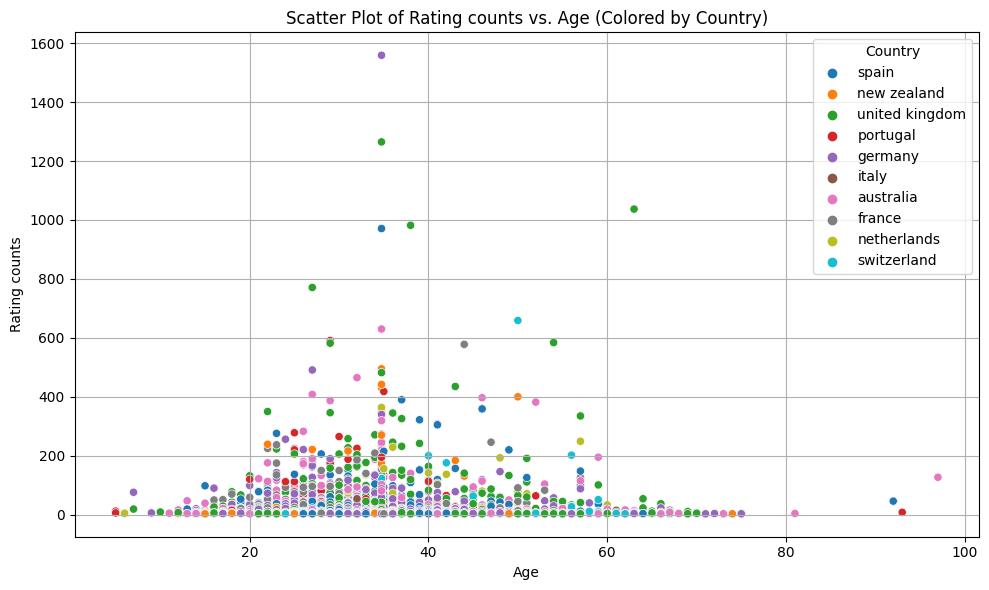

In [224]:
# Create a scatter plot with 'country' as the color feature using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='num_ratings', hue='country', data=filtered_df, palette='tab10')
plt.xlabel('Age')
plt.ylabel('Rating counts')
plt.title('Scatter Plot of Rating counts vs. Age (Colored by Country)')
plt.grid(True)
plt.legend(title='Country', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

We can see that people ranging from age 20 and age 60 contributed the most to our dataset. Then teenagers rated a bit less. Lastly, people aging more than 60 rarely rated. That means when we try to give recomendations to elderly, we might compute the similarity between them with the middle aged people. And I don't think there are similarities at all between elderly and teenages. But this should be verified.

# Data exploration with utility matrix

In this section, we try to manipolate the data in the form of matrix, and process the dataset.

## Extracting utility matrix

### Debiasing method

As we see in the data exploration section, most of the users who provided data were NA users, it may be biased if we want to provide recomendation to other users who comes from rare regione.

For this reason, we can select k random ratings across all countries. Then we will have a fair dataset that is less biased.

In [225]:
ratings_df =df[["user_id","isbn","rating", "country"]]
ratings_df.head(5)

,user_id,isbn,rating,country
0,2,0195153448,0,usa
1,8,0002005018,5,canada
2,11400,0002005018,0,canada
3,11676,0002005018,8,NaN
4,41385,0002005018,0,canada


From the data shown above, we drop those who has average rating `0`, those who rated zero, but their average score is not will be kept.

In [226]:
# Calculate the average rating for each user
user_avg_rating = ratings_df.groupby('user_id')['rating'].mean().reset_index()

# Filter out users with an average rating of 0 and more than 1 rating
filtered_users = user_avg_rating[(user_avg_rating['rating'] != 0) & (user_avg_rating['rating'].notna())]

# Merge the filtered user list with the original ratings_df to get the filtered dataset
filtered_ratings_df = pd.merge(ratings_df, filtered_users, on='user_id', how='inner')

# Drop the extra rating column (the average rating)
filtered_ratings_df = filtered_ratings_df.drop(columns=['rating_y'])

# Rename the remaining rating column to 'rating'
ratings_df = filtered_ratings_df.rename(columns={'rating_x': 'rating'})
ratings_df

,user_id,isbn,rating,country
0,8,0002005018,5,canada
1,8,0060973129,0,canada
2,8,0374157065,0,canada
3,8,0393045218,0,canada
4,8,0399135782,0,canada
...,...,...,...,...
987544,278376,0060530103,7,usa
987545,278621,1550390961,8,canada
987546,278636,0375507299,5,usa
987547,278659,0345330293,10,usa


Then we randomly select k ratings from each country, and only counties of which has at least k ratings.

In [227]:
# Define the value of k
k = 420

# Group the ratings_df by 'country'
grouped = ratings_df.groupby('country')

# Initialize an empty list to store the selected data
selected_data = []

# Loop through each group (country)
for name, group in grouped:
    # Check if there are at least k users in the country
    if len(group) >= k:
        # Sort the group by 'rating' column in descending order and select the top k users
        top_k_users = group.head(k)
        # Append the selected data to the list
        selected_data.append(top_k_users)

# Create a new DataFrame by concatenating the selected data
result_df = pd.concat(selected_data)

# Reset the index of the result DataFrame
result_df.reset_index(drop=True, inplace=True)

# Print the result DataFrame
result_df

,user_id,isbn,rating,country
0,133706,0440234743,8,australia
1,133706,0380718332,8,australia
2,133706,0425163407,7,australia
3,133706,0440224764,7,australia
4,133706,0446605484,8,australia
...,...,...,...,...
11335,110912,0553260960,0,usa
11336,110912,0679450742,0,usa
11337,110912,0553089226,0,usa
11338,110912,0449204324,0,usa


In [228]:
ratings = result_df.drop(columns=['country'])

### Max rating counts method

You can select this method to create a different dataset, the difference between this `max rating counts method` and `debiasing method` is that, this methods tries to contain users with more ratings, that makes the matrix more populated; In the mean while, the debiasing method provides a general dataset to reduce biases in the valuation.

In [229]:
#set_size=200000
#ratings = df[:set_size]
#ratings = ratings_df

In [230]:
#Don't comment this, because to work with matrix, we need to unstack the dataframe
ratings.set_index(["user_id", "isbn"], inplace=True)
ratings = ratings["rating"].unstack("isbn").astype(pd.SparseDtype("float", np.nan))
#ratings['count_non_null'] = ratings.count(axis=1)

In [231]:
'''
# Sort by 'count_non_null' in descending order
sorted_ratings = ratings.sort_values(by='count_non_null', ascending=False)

# Take the top 200 rows
top_200_ratings = sorted_ratings.head(2)

# Drop the 'count_non_null' column
top_200_ratings = top_200_ratings.drop(columns=['count_non_null'])

# Create a new matrix (numpy array) from the top 200 rows
ratings = top_200_ratings'''

"\n# Sort by 'count_non_null' in descending order\nsorted_ratings = ratings.sort_values(by='count_non_null', ascending=False)\n\n# Take the top 200 rows\ntop_200_ratings = sorted_ratings.head(2)\n\n# Drop the 'count_non_null' column\ntop_200_ratings = top_200_ratings.drop(columns=['count_non_null'])\n\n# Create a new matrix (numpy array) from the top 200 rows\nratings = top_200_ratings"

In [232]:
ratings.head(5)

isbn,0001055607,0001935968,000195833X,0002000288,0002005018,0002005050,0002005557,0002160595,0002215497,0002233711,...,9971655292,997951079X,9995585227,B000051ZUO,B00005BBW4,B00005NCS7,B00005Q8OL,B00005U7YK,B000069F44,B00009MBYK
user_id,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### K nearest neighbour similarity matrix

In [233]:
R = ratings.fillna(0).values
R[:5, :5]

array([[0., 0., 0., 0., 5.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [234]:
P = ratings.notna().values
P[:5, :5]

array([[False, False, False, False,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

Extracting useful information from the matrix `P` and `R`.

In [235]:
print("number of ratings:", P.sum())
print("number of users who has rated a book", P.shape[0])
print("number of books: ", P.shape[1])
print("average ratings from users: ", R.mean(where=P))
print("average rate of rating: ", P.sum()/P.shape[0])

print("the maximum numbers of ratings given by an user: ",P.sum(1).max())
print("the book with minimum number of ratings: ", P.sum(0).min())

number of ratings: 11340
number of users who has rated a book 229
number of books:  9023
average ratings from users:  3.0936507936507938
average rate of rating:  49.519650655021834
the maximum numbers of ratings given by an user:  420
the book with minimum number of ratings:  1


In [236]:
isbn = ratings.columns[P.sum(0).argmax()]
book_name = df[df['isbn'] == isbn]['book_title']
print("the book name with maximum number of ratings:")
book_name.head(1)

the book name with maximum number of ratings:


769    Wild Animus
Name: book_title, dtype: object

In [237]:
print("5 books with the most average rating:")
indexes = (-R.mean(0, where=P)).argsort()[:5]
book_isbns = ratings.columns[indexes]
#book_with_most_rating_names = [df[df['isbn'] == name]['book_title'] for name in book_isbns]
book_isbns

5 books with the most average rating:


Index(['0141003944', '1551665395', '1551664704', '1551662922', '1551108631'], dtype='object', name='isbn')

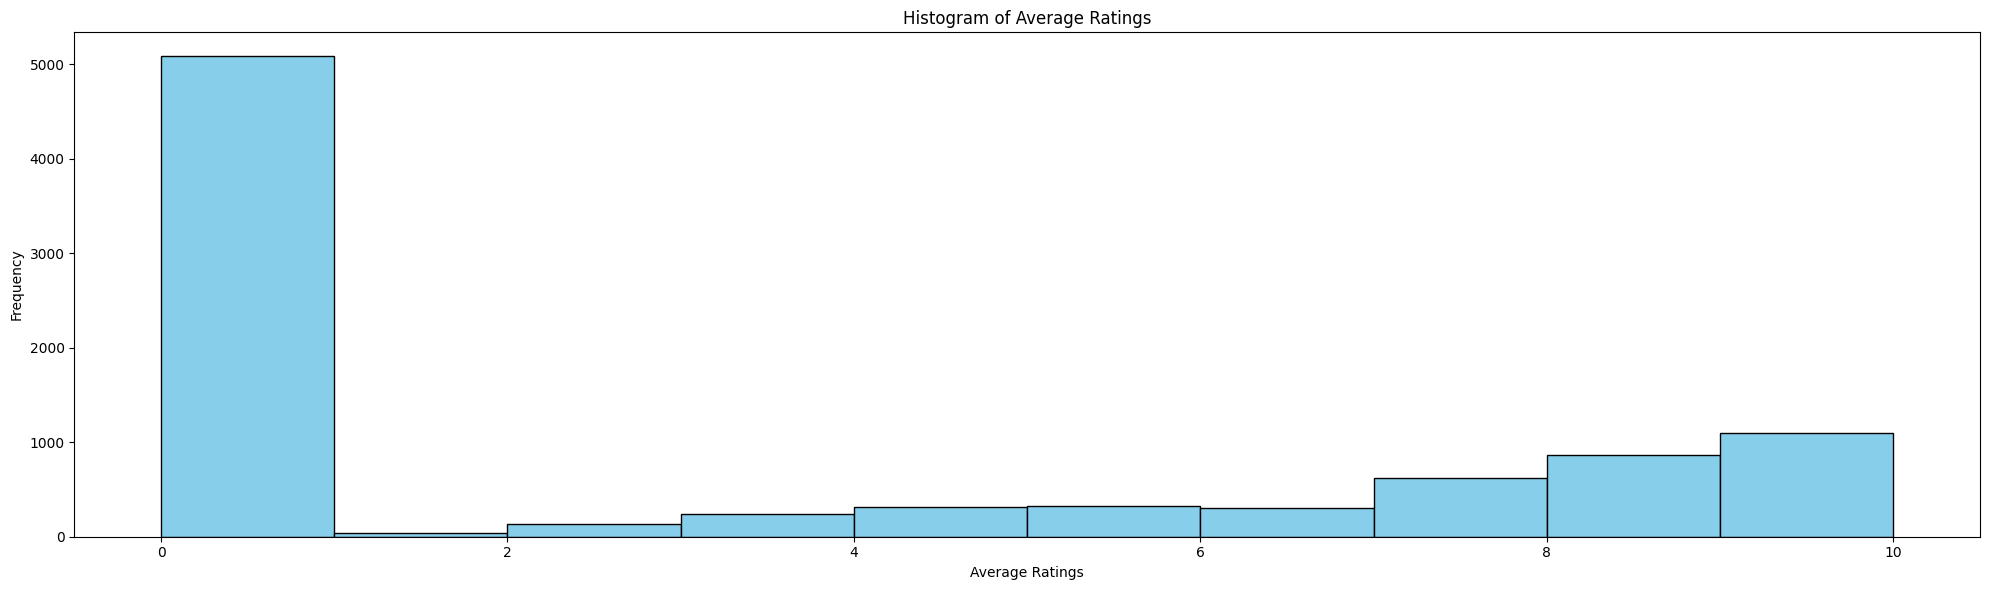

In [238]:
most_rated_books_average_ratings = -np.sort((-R.mean(0, where=P)))
plt.figure(figsize=(20, 6))
plt.hist(most_rated_books_average_ratings, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency') # the number of book that share the same average rating score
plt.title('Histogram of Average Ratings')
plt.tight_layout()
plt.show()

# Data preparation

## Prepare training set and validation set

Now we split the dataset into training set and validation set, we split the 80% for the training set, and 20% for the validation set.

But since this is a recomendation dataset, we want to traing set to be the data we have in the year, let's say 2009. The validation set then contrains new data of same users, let's suppose 2011.

We only have 1 dataset, so we randomly drop 20% of data, and let it be the traing set. Consequently, the original complete dataset will be used to validation.

In [239]:
division_index = 0.8
val_set = ratings.sparse.to_dense()

In [240]:
# Convertiamo il DataFrame sparsa in uno denso
dense_ratings = ratings.sparse.to_dense()

train_set = pd.DataFrame(index=dense_ratings.index, columns=dense_ratings.columns)
train_set[:] = np.nan

# Itera sulle righe
for index, row in dense_ratings.iterrows():
    non_nan_indices = row.dropna().index
    if len(non_nan_indices) == 1:
        train_set.at[index, non_nan_indices[0]] = dense_ratings.at[index, non_nan_indices[0]]
    else:
        num_samples = len(non_nan_indices)
        train_samples_idx = np.random.choice(num_samples, size=int(division_index * num_samples), replace=False)
        selected_indices = [non_nan_indices[i] for i in train_samples_idx]
        for j in selected_indices:
            train_set.at[index, j] = dense_ratings.at[index, j]

# Converti nuovamente in sparsa
train_set = train_set.astype(pd.SparseDtype("float", np.nan))


In [241]:
del dense_ratings
gc.collect()

0

In [242]:
val_set.head(3)

isbn,0001055607,0001935968,000195833X,0002000288,0002005018,0002005050,0002005557,0002160595,0002215497,0002233711,...,9971655292,997951079X,9995585227,B000051ZUO,B00005BBW4,B00005NCS7,B00005Q8OL,B00005U7YK,B000069F44,B00009MBYK
user_id,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
train_set.head(3)

isbn,0001055607,0001935968,000195833X,0002000288,0002005018,0002005050,0002005557,0002160595,0002215497,0002233711,...,9971655292,997951079X,9995585227,B000051ZUO,B00005BBW4,B00005NCS7,B00005Q8OL,B00005U7YK,B000069F44,B00009MBYK
user_id,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next we check validation and training set have the same shape and index as to calculate RMSE we need the same structure.

In [244]:
val_set.shape == train_set.shape

True

In [245]:
val_set = val_set.reindex_like(train_set)

In [246]:
np.array_equal(train_set.index, val_set.index)

True

In [247]:
np.array_equal(train_set.columns, val_set.columns)

True

We then calculate the value matrix without Nan rating and the relative boolean matrix for both sets of data.

In [248]:
R_train = train_set.fillna(0).values
P_train = train_set.notna().values

R_val = val_set.fillna(0).values
P_val = val_set.notna().values

In [249]:
val_actual = R_val[P_val]

# Prediction without models

## Collaborative prediction

Similarity calculation between an user `a` and an user `b` over item `i`:
$$ \text{sim}(u,v) = \frac{\sum_{i\in C_{u,v}} r_{u,i}\cdot r_{v,i}}{\sqrt{\sum_{i\in C_{u,v}} r_{u,i}^2}\cdot\sqrt{\sum_{i\in C_{u,v}} r_{v,i}^2}}$$

In [250]:
R = R_train
P = P_train
print(R.shape, P.shape) # = M X N
# Where M is the number of users and N is the number of items

(229, 9023) (229, 9023)


if i want to get the cos similarity bewteen users (m x n) @ (n x m) = (m x m) which is (user_dim x user_dim)

In [251]:
sim_numerator = R @ R.T
sim_numerator.shape

(229, 229)

In order to calculate the denominator, we need the norm of the scores between a pair of users, and we will only take the scores where the matrix P shows `True`

In [252]:
# a vector of dimension m x m x n, that is (user, user, boolean)
# we have m x n,  so we need to add 1 dimension to m
# that can be (1, m, n) and (m, 1, n)
P_rated = P[None, :, :] & P[:, None, :]
P_rated.shape

(229, 229, 9023)

Now we need a 3d vector of dimension (m x m x n), that is (user, user, score), this matrix contains information about ratings of items only if the item is rated by both users

In [253]:
#(m x m x n) * (1, m, n) = (m, m, n)
R_both_rated = P_rated * R
R_both_rated.shape
# although in this case, we have (m,m,n), but the score
#will be of the user in the second dimension(dim=1) in the 3d array (_, m, _)

(229, 229, 9023)

Now we can calculate the normalization of the denominator

In [254]:
R_both_rated_norm = np.linalg.norm(R_both_rated, axis=2)
#axis = 2 because that is the dimension where rating is saved
R_both_rated_norm.shape

(229, 229)

Then, we get the square of the values of the matrix
$${\sqrt{\sum_{i\in C_{u,v}} r_{u,i}^2}\cdot\sqrt{\sum_{i\in C_{u,v}} r_{v,i}^2}}$$

In [255]:
similarity_denominator = R_both_rated_norm * R_both_rated_norm.T
similarity_denominator.shape

(229, 229)

In [256]:
cosin_sim = sim_numerator / similarity_denominator
cosin_sim[:5, :5]

array([[ 1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan],
       [nan, nan,  1., nan, nan],
       [nan, nan, nan,  1., nan],
       [nan, nan, nan, nan,  1.]])

We replace nan with the value zero

In [257]:
cosin_sim = np.where(np.isnan(cosin_sim), 0, cosin_sim)
cosin_sim[:50, :50]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

When we have a sparse matrix, this would not work so well.

Now we can test this method on our validation dataset

In [258]:
def get_val_predictions(pred_func, k):
    return np.array([
        pred_func(u, i, k)
        for u, i in zip(*P_val.nonzero())
    ])

In [259]:
def RMSE(actual, predicted):
    return np.sqrt(np.mean(np.square(predicted - actual)))

In [260]:
def predict_from_neighbors(u, i, k):
    voters = list(P[:, i].nonzero()[0])
    voters.sort(key=lambda x: cosin_sim[u, x], reverse=True)
    voters = voters[:k]
    predicted_vote = (cosin_sim[u, voters] @ R[voters, i]) / cosin_sim[u, voters].sum()
    return predicted_vote if not np.isnan(predicted_vote) else R[P].mean()

In [261]:
K_similar_users = 5

In [262]:
k_sim_mserr = [RMSE(val_actual, get_val_predictions(predict_from_neighbors, k)) for k in range(K_similar_users)]

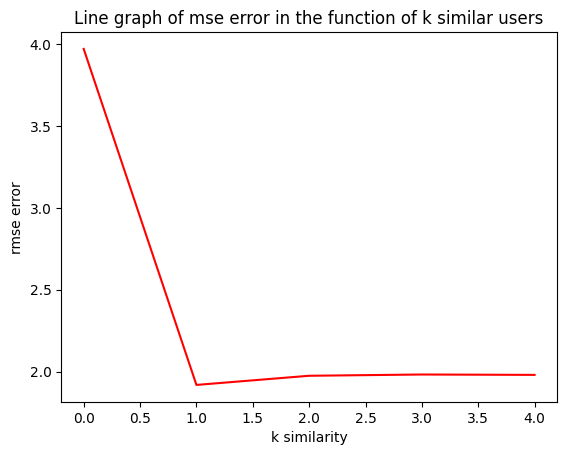

In [263]:
plt.title("Line graph of mse error in the function of k similar users")
plt.xlabel("k similarity")
plt.ylabel("rmse error")
plt.plot(np.arange(K_similar_users), k_sim_mserr, color ="red")
plt.show()

From this chart, we can see that there is no neccessary that we need to compute the similarity among all users, but just 1 neighbour is enough.

In [264]:
print(P.shape[0])

229


In [265]:
val_predictions = get_val_predictions(predict_from_neighbors, P.shape[0])
RMSE(val_actual, val_predictions)

1.9781076231462658

In [266]:
val_predictions = get_val_predictions(predict_from_neighbors, 3)
RMSE(val_actual, val_predictions)

1.9819640070675235

# Prediction with models

## Bayesian model


In [267]:
#function with calculate the [0-100]% of non-NaN elements of a matrix

def percentile_of_non_nan(matrix):
    # Count non-NaN values
    non_nan_count = np.sum(~np.isnan(matrix))

    # Total number of elements in the matrix
    total_elements = matrix.size

    # Compute the percentile
    percentile = (non_nan_count / total_elements) * 100
    return percentile

as we can see nex,t we have a very low populated user matrix. teorically our bayesian model is not suitable for this case.

In [268]:
#percentile_of_non_nan(matrix)

This function calculate the highest bayesian probability of a user for all of his non-rated books. I'ts calculate as max P(X| Y = rating ) while rating being in a range of [0...10] and X the know rating of user.

In [269]:
def bayesian_recommendation(matrix, user_vector):
    num_books = matrix.shape[1]

    best_ratings_for_user = []

    #1. we have an user A
    #2. we then select all other users who rated same items that user A has rated
    #3. we fill user A 's vector, so user A should have a predicted rating for all items
    #4. We accumulate values of probability for the target_score. It should be :
    #5. P(X | Item5=target_score) = P(Item1=1 | Item5=target_score) * P(Item2=3 | Item5=target_score)
    #* P(Item3=3 | Item5=target_score) * P(Item4=1 | Item5=target_score)
    # * P(Item5=target_score) for target_score in range(11)



    #boolean mask to indentify rated items of user A
    rated_by_user = ~np.isnan(user_vector)

    # boolean mask to filtering same user who voted the same books
    similar_users_mask = ~np.isnan(matrix[:, rated_by_user]).all(axis=1)
    filtered_matrix = matrix[similar_users_mask]

    for i in range(num_books):
        # skip books alredy rated
        if not np.isnan(user_vector[i]):
            best_ratings_for_user.append(user_vector[i])
            continue

        best_rating_for_book = None
        best_prob = -np.inf

        # calculate every rating probability
        unique_ratings, counts = np.unique(filtered_matrix[:, i][~np.isnan(filtered_matrix[:, i])], return_counts=True)
        total_ratings = np.sum(counts)
        p_y = dict(zip(unique_ratings, counts / total_ratings))

        for rating in range(11):  # 0-10 ratings
            # semplyfied version of P(X|Y=rating)
            p_x_given_y = np.nanmean(filtered_matrix[:, i] == rating)

            # calculate P(Y=rating|X) as P(X|Y) * P(Y)
            p_y_given_x = p_x_given_y * p_y.get(rating, 0)

            if p_y_given_x > best_prob:
                best_prob = p_y_given_x
                best_rating_for_book = rating

        best_ratings_for_user.append(best_rating_for_book)

    return best_ratings_for_user


convert our train and valuetion set to numpy matrix to execute the bayesian model.

In [270]:
matrix = train_set.to_numpy()
user_matrix =val_set.to_numpy()
predicted_matrix = np.zeros_like(matrix)

In [271]:
def RMSE(actual, predicted):
    mask = ~np.isnan(actual)
    actual_filtered = actual[mask]
    predicted_filtered = predicted[mask]
    return np.sqrt(np.mean(np.square(predicted_filtered - actual_filtered)))

In [272]:
#uncomment to execute bayesian model
for user_idx in range(5):
    # Clone user ratings from training set
    user_ratings = matrix[user_idx].copy()
    # Get predicted ratings for the user
    predictions = bayesian_recommendation(matrix, user_ratings)

    # Update the predicted_matrix with modified ratings
    predicted_matrix[user_idx] = np.array(predictions)

total_rmse = RMSE(user_matrix,predicted_matrix)
print("RMSE between validation and predicted matrices:", total_rmse)

RMSE between validation and predicted matrices: 5.0244990624861465


In [273]:
user_vector = matrix[114]
output = bayesian_recommendation(matrix, user_vector)

The output vector than will be the complete rating prediction of user A

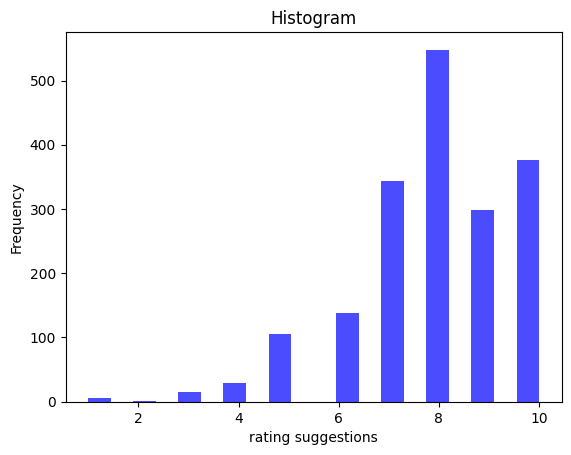

In [274]:
# Create a histogram
plt.hist([output[i] for i in np.array(output).nonzero()[0]], bins=20, color='blue', alpha=0.7)

# Customize the plot (optional)
plt.title('Histogram')
plt.xlabel('rating suggestions')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

As the above chart despicts, the bayesian model gives only zero values, or high confidential recommendations. It should be used when we have rich user data.

## User based filtering

Let's import the library surprise.

In [275]:
!pip install scikit-surprise

we convert our data set in a dataframe structure to subsequently convert to a suprise dataset.

## Surprise data trainset, valueset preparation

In [276]:
train_set_stacked = train_set.stack()
train_set_stacked = train_set_stacked.reset_index()

train_set_stacked = train_set.stack()
train_set_stacked = train_set_stacked.reset_index()

val_set_stacked = val_set.stack()
val_set_stacked = val_set_stacked.reset_index()


we perform some modifications to rating values to avoid float division for zero before building surprise's dataset.

In [277]:
from surprise import Dataset
from surprise import Reader
from surprise.dataset import DatasetAutoFolds

reader = Reader(rating_scale=(1e-5, 10))

train_dataset = Dataset.load_from_df(train_set_stacked, reader)
train_dataset = pd.DataFrame(train_dataset.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
train_dataset[train_dataset["rating"] == 0] = 1e-5
train_dataset = train_dataset.drop(columns=["timestamp"])
train_dataset = Dataset.load_from_df(train_dataset, reader)

val_dataset = Dataset.load_from_df(val_set_stacked, reader)
val_dataset = pd.DataFrame(val_dataset.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
val_dataset[val_dataset["rating"] == 0] = 1e-5
val_dataset = val_dataset.drop(columns=["timestamp"])
val_dataset = Dataset.load_from_df(val_dataset, reader)


In [278]:
trainset = train_dataset.build_full_trainset()
valset = val_dataset.build_full_trainset().build_testset()

In [279]:
evaluation_results = {}

### KNN

we already utilized the hand-crafted cosine similarity and we want to compare the result with the surpise's algorithm.

In [280]:
from surprise import KNNBasic
model = KNNBasic(k=trainset.n_users, sim_options={"name": "cosine"})

In [281]:
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [282]:
model.sim[:4, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

we conduct the evaluetion with RMSE(root mean sqaured error) and MAE(mean absolute error).

In [283]:
from surprise.accuracy import rmse
from surprise.accuracy import mae

In [284]:
preds = model.test(valset)
evaluation_results["knn-basic cosin"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)


RMSE: 1.4370
MAE:  0.4268
RMSE: 1.4370
MAE:  0.4268


(1.4369940447648986, 0.4268480246100624)

we tried to predict the rating score to a book from a chosen user.

In [285]:
user0 = ratings.index[0]
item0 = ratings.columns[0]
pred = model.predict(user0, item0)
pred

Prediction(uid=8, iid='0001055607', r_ui=None, est=3.0875810669037564, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

### Pearson

Pearson is another method to calculate the similarity between users. But its formula is different to the cosin similarity, it uses covariance matrix and standard deviations to calculate the similarity. It is a popular method.

In [286]:
model = KNNBasic(k=10, sim_options={"name": "pearson"})
model.fit(trainset)
preds = model.test(valset)
evaluation_results["knn-basic Pearson"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4392
MAE:  0.3936
RMSE: 1.4392
MAE:  0.3936


(1.4391605845856574, 0.39359549126651316)

### Kmeans

Kmeans is a method that computes user ratings considering the mean rating of user `a`, and weighted deviation of ratings to the item `i` given by the user `b`. It should give a more precise prediction.

In [287]:
from surprise import KNNWithMeans
model = KNNWithMeans(k=10, sim_options={"name": "cosine"})
model.fit(trainset)
preds = model.test(valset)
evaluation_results["knn-means cosin"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3356
MAE:  0.3783
RMSE: 1.3356
MAE:  0.3783


(1.3355601938847714, 0.3782733788305065)

In [288]:
from surprise import KNNWithMeans
model = KNNWithMeans(k=10, sim_options={"name": "pearson"})
model.fit(trainset)
preds = model.test(valset)
evaluation_results["knn-means pearson"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3143
MAE:  0.3401
RMSE: 1.3143
MAE:  0.3401


(1.3142967372431769, 0.3400894270356157)

## Item based

Same method as cosin similarity user-based, but we measure the similarity between items.

In [289]:
model = KNNBasic(k=10, sim_options={"name": "cosine", "user_based": False})
model.fit(trainset)
preds = model.test(valset)
evaluation_results["Item based"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6359
MAE:  0.7176
RMSE: 1.6359
MAE:  0.7176


(1.6359265266589729, 0.7176454429725706)

## svd

we use SVD matrix factorization reduce the dimension of utility matrix

In [290]:
from surprise import SVD
model = SVD(n_factors=10, random_state=42)
model.fit(trainset)
preds = model.test(valset)
evaluation_results["SVD"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

RMSE: 1.0348
MAE:  0.5099
RMSE: 1.0348
MAE:  0.5099


(1.0347896119617606, 0.5098789763466576)

In [291]:
user0 = ratings.index[0]
item0 = ratings.columns[0]

In [292]:
model.predict(user0, item0)

Prediction(uid=8, iid='0001055607', r_ui=None, est=3.958031729404538, details={'was_impossible': False})

## Random recomendation

In [293]:
from surprise import NormalPredictor
model = NormalPredictor()
model.fit(trainset)
preds = model.test(valset)
evaluation_results["random"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

RMSE: 5.0542
MAE:  4.0167
RMSE: 5.0542
MAE:  4.0167


(5.054168497745541, 4.01672174533289)

## Slop One

Slop One is a method based on calculating the derivatives between a pair of items. Every pair of items may have the same change in the ratings, but different initial rating score.

In [294]:
from surprise import SlopeOne
model = SlopeOne()
model.fit(trainset)
preds = model.test(valset)
evaluation_results["slop one"] = (rmse(preds), mae(preds))
rmse(preds), mae(preds)

RMSE: 1.3158
MAE:  0.3392
RMSE: 1.3158
MAE:  0.3392


(1.3157994610536374, 0.3391922309606131)

<Figure size 1000x600 with 0 Axes>

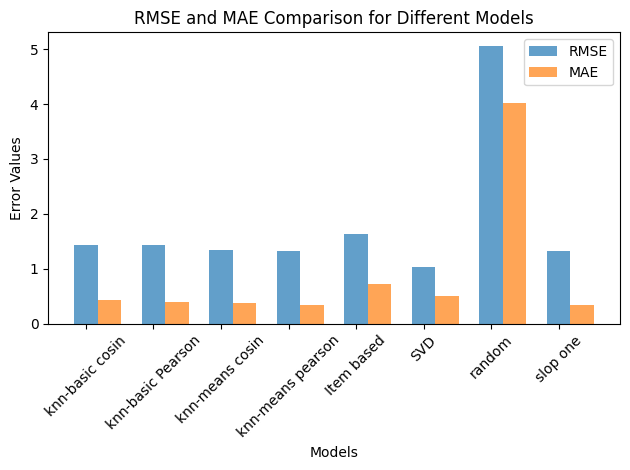

In [303]:
# Extract labels, RMSE, and MAE values from the dictionary
labels = list(evaluation_results.keys())
rmse_values = [result[0] for result in evaluation_results.values()]
mae_values = [result[1] for result in evaluation_results.values()]

# Convert labels to numerical values for plotting
x = np.arange(len(labels))

 #Set the figure size and rotate x-axis labels
plt.figure(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.35

# Create figure and axes
fig, ax = plt.subplots()

# Create bars for RMSE
bar1 = ax.bar(x, rmse_values, bar_width, label='RMSE', alpha=0.7)

# Create bars for MAE
bar2 = ax.bar(x + bar_width, mae_values, bar_width, label='MAE', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('RMSE and MAE Comparison for Different Models')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)
plt.xticks(x, labels, rotation=45)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()


## Grid Search

We utilize a primal algorithm from suprise which allowed us to find the optimal hyperparameters for our dataset.

In [308]:
from surprise.model_selection import GridSearchCV

In [ ]:
# Assuming you've loaded your data to train_dataset
# train_dataset = Dataset.load_builtin("ml-100k").build_full_trainset()

# List of models and their respective hyperparameter grids
models = [
    (KNNBasic, {"k": [5, 10, 20], "sim_options": {"name": ["cosine", "pearson"], "user_based": [True, False]}}),
    (KNNWithMeans, {"k": [5, 10, 20], "sim_options": {"name": ["cosine", "pearson"], "user_based": [True, False]}}),
    (SlopeOne, {}),
    (SVD, {"n_factors": list(range(1, 20, 3))}),
]

# Perform grid search for each model
for model_class, hyperparameters in models:
    print(f"Grid search for {model_class.__name__}")

    # Create the grid search object
    gs = GridSearchCV(model_class, hyperparameters, measures=['rmse'], cv=5)

    # Fit the grid search on the data
    gs.fit(train_dataset)

    # Print the best parameters and their corresponding RMSE
    print("Best Parameters:", gs.best_params['rmse'])
    print("Best RMSE:", gs.best_score['rmse'])
    print()

Best Parameters: {'k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}

Best RMSE: 3.1241662102682914

Best Parameters: {'k': 5, 'sim_options': {'name': 'pearson', 'user_based': True}}

Best RMSE: 2.953555134974674

Grid search for svd
Best Parameters: {'n_factors': 1}

Best RMSE: 1.2975140685381652


## Cross validation k-fold


By leveraging the cross validation technique,  we split the data into multiple chuncks to perform training and valuation. This will make a better valuation.

In [304]:
from surprise.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [341]:
from surprise.model_selection import cross_validate

Cross-validation for KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.1211  3.1393  3.1154  3.1340  3.0725  3.1164  0.0236  
MAE (testset)     1.8358  1.8517  1.8321  1.8475  1.8054  1.8345  0.0162  
Fit time          0.60    0.55    0.56    0.81    0.59    0.62    0.10    
Test time         1.88    1.93    1.89    3.26    1.91    2.17    0.54    
Average RMSE: 3.1164457844773708
Average MAE: 1.8344972494214873

Cross-validation for KNNWithMeans
Computing the pearson similarity matrix...
Done computin

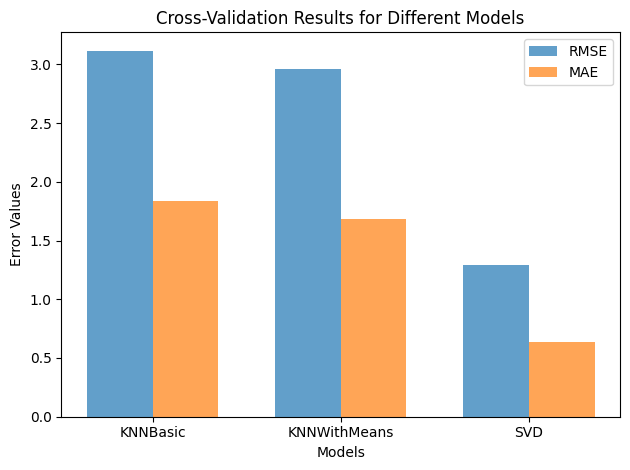

In [343]:
# Best parameters obtained from grid search
best_knn_basic_params = {'k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}
best_knn_with_means_params = {'k': 5, 'sim_options': {'name': 'pearson', 'user_based': True}}
best_svd_params = {'n_factors': 1}

# Create instances of the models with best parameters
best_knn_basic = KNNBasic(**best_knn_basic_params)
best_knn_with_means = KNNWithMeans(**best_knn_with_means_params)
best_svd = SVD(**best_svd_params)

# List of models
models = [
    best_knn_basic,
    best_knn_with_means,
    best_svd,
]

# Lists to store RMSE and MAE scores
rmse_scores = []
mae_scores = []

# Perform cross-validation for each model
for model in models:
    print(f"Cross-validation for {model.__class__.__name__}")

    # Perform 5-fold cross-validation
    results = cross_validate(model, train_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    # Print the average RMSE and MAE scores over the folds
    rmse_avg = results['test_rmse'].mean()
    mae_avg = results['test_mae'].mean()

    print(f"Average RMSE: {rmse_avg}")
    print(f"Average MAE: {mae_avg}")
    print()

    # Append RMSE and MAE scores to the lists
    rmse_scores.append(rmse_avg)
    mae_scores.append(mae_avg)

# Model names
model_names = ['KNNBasic', 'KNNWithMeans', 'SVD']

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Set the width of the bars
bar_width = 0.35

# Create figure and axes
fig, ax = plt.subplots()

# Create bars for RMSE
bar1 = ax.bar(x, rmse_scores, bar_width, label='RMSE', alpha=0.7)

# Create bars for MAE
bar2 = ax.bar(x + bar_width, mae_scores, bar_width, label='MAE', alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('Cross-Validation Results for Different Models')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()


## Recomendations to the user


Lastly, we provide a recommendation system that shows the most relevant proposals based on similar user.

In [313]:
target_user = 0

In [314]:
preds = [
    gs.predict(target_user, trainset.to_raw_iid(ii))
    for ii in range(trainset.n_items)
]

In [315]:
for p in sorted(preds, key=lambda p: p.est, reverse=True)[:10]:
  isbn = p.iid
  book_title = df[df['isbn'] == isbn]['book_title'].values[0]
  print(isbn, book_title)


0440226430 Summer Sisters
0446310786 To Kill a Mockingbird
0440234743 The Testament
0385504209 The Da Vinci Code
0439136369 Harry Potter and the Prisoner of Azkaban (Book 3)
0316666343 The Lovely Bones: A Novel
0452264464 Beloved (Plume Contemporary Fiction)
0413537900 The Secret Diary of Adrian Mole Aged 13 3/4
0140620222 Pride and Prejudice (Penguin Popular Classics)
0590660543 Northern Lights (His Dark Materials S.)


## Content based

We provide a way to give recommendations based on the content, given a book title, the recommender will find similar books based on the 4 features. This method should be used when we lack the user data, or an user simply wants to search the book of his interest.

In [316]:
#The function code comes from here:
#https://www.kaggle.com/code/sercanyesiloz/book-recommendation-system?scriptVersionId=72695776&cellId=16

In [317]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image

In [318]:
def content_based_recommender(book_title):

    book_title = str(book_title)
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]

        if book_title in rare_books:

            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')

        else:

            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]

            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())

            print(books)

    else:

        print('Cant find book in dataset, please check spelling')

It uses the CountVectorizer to convert the 'combined_features' into a count matrix, which represents the presence of each word in the text.

It computes cosine similarity between the count matrix of texts and stores it in the cosine_sim variable.

One example could be:

Harry | Potter | J.K. | Rowling | Bloomsbury | Fantasy | Twilight | Stephenie | Meyer | Little | Brown | Fiction
------|-------|------|--------|------------|---------|---------|----------|------|-------|------|--------
  1   |   1   |  1   |   1    |     1      |    1    |    0    |    0     |  0   |   1   |  0   |   0
  1   |   1   |  0   |   0    |     0      |    0    |    1    |    1     |  1   |   1   |  1   |   1

If the combined feature of both books contains the word `Harry` and `Potter`, then they are similar in the content!

We try with one book, let's get other books with similar content!

In [319]:
book_title = df.iloc[1024, :]['book_title']
print("the book title is", book_title)
content_based_recommender(book_title)

the book title is Wild Animus
['Beloved (Plume Contemporary Fiction)', 'Bleachers', 'Neverwhere', 'Dreamcatcher', 'Choke']
